In [1]:
%matplotlib inline


In [2]:
import mne
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
from mne.datasets import sample
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname)
info = raw.info

Opening raw data file /home/david/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0


In [4]:
data = mne.externals.h5io.read_hdf5('/home/david/data/camcan/outputs/covs_allch_oas.float32.h5')

In [5]:
data[0]['covs'].shape

(9, 306, 306)

In [7]:
mne.Covariance?

In [6]:
cov = mne.Covariance(data[0]['covs'][0], raw.ch_names[:306], [], [], 1)

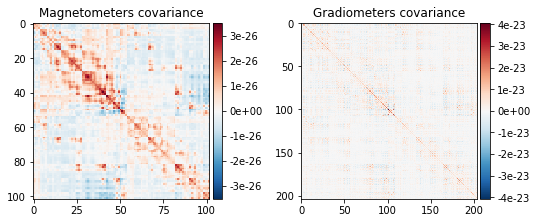

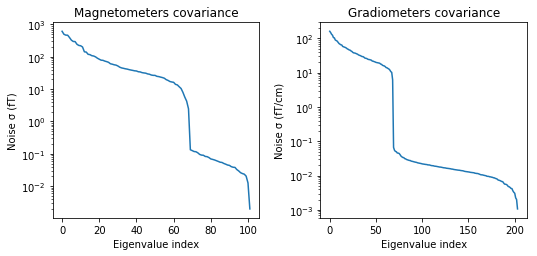

(<Figure size 547.2x266.4 with 4 Axes>, <Figure size 547.2x266.4 with 2 Axes>)

In [7]:
mne.viz.plot_cov(cov, info)

In [8]:
mne.compute_rank(cov, info=info)

Computing data rank from covariance with rank=None
Using tolerance 1.9e-13 (2.2e-16 eps * 305 dim * 2.7 max  singular value)
estimated rank (mag + grad): 302
    MEG: rank 302 computed from 3s data channels with 305 projectors


{'meg': 302}

In [28]:
import copy as cp

from scipy.linalg import pinv, eigh
from sklearn.base import TransformerMixin, BaseEstimator

from mne import EvokedArray


def shrink(cov, alpha):
    n = len(cov)
    shrink_cov = (1 - alpha) * cov + alpha * np.eye(n)
    return shrink_cov


def fstd(y):
    y = y.astype(np.float64)
    y -= y.mean(axis=0)
    y /= y.std(axis=0)
    return y


class SPoC(TransformerMixin):
    def __init__(self, covs=None, fbands=None,
                 spoc=True, n_components=2, alpha=0):
        #self.covs = covs[:, :, picks][:, :, :, picks]  # (sub,fb,chan,chan)
        self.covs = covs # (sub,fb,chan,chan)
#        if spoc:
#            self.covs = np.array([[cov/np.trace(cov)
#                                   for cov in self.covs[sub]]
#                                  for sub in range(len(self.covs))])
        self.picks = picks  # XXX do it outside !
        self.fbands = fbands
        self.spoc = spoc
        self.n_components = n_components
        self.alpha = alpha

    def fit(self, X, y):
        target = fstd(y)
        self.patterns_ = []
        self.filters_ = []
        for fb in range(len(self.fbands)):
            if self.spoc:
                covsfb = self.covs[:, fb]
                C = covsfb[X].mean(axis=0)
                C /= np.trace(C)
                
                Cz = np.mean(covsfb[X] * target[:, None, None],
                            axis=0)
                C = shrink(C, self.alpha)
                eigvals, eigvecs = eigh(Cz, C)
                eigvals = eigvals.real
                eigvecs = eigvecs.real
                ix = np.argsort(np.abs(eigvals))[::-1]
#                 ix = np.argsort(np.abs(eigvals - 0.5))[::-1]

                evecs = eigvecs[:, ix].T
                self.patterns_.append(pinv(evecs).T)  # (fb, chan,chan)
                self.filters_.append(evecs)  # (fb, chan,chan) row vec
            else:
                self.n_components = len(self.picks)
                self.patterns_.append(np.eye(self.n_components))
                self.filters_.append(np.eye(self.n_components))
        return self

#    def transform2(self, X):
#        powers = []
#        for fb in range(len(self.fbands)):
#             filters = np.array(self.filters_[fb][:self.n_components])
#             # (comp,chan)
#             powers.append([np.diag(filters @ self.covs[sub, fb] @ filters.T)
#                            for sub in X])
#        powers = np.log10(powers)  # (fb, sub, compo,)
#        self.features = powers.transpose(1, 2, 0).reshape(len(X), -1)
#        return self.features  # (sub,compo*fb)
    
    def transform(self, X):
        Xf = np.empty((X.size, self.n_components, len(self.fbands)))
        for fb in range(len(self.fbands)):
            filters = self.filters_[fb][:self.n_components]
            # (comp,chan)
            this_Xf = [np.diag(filters @ self.covs[sub, fb] @ filters.T) for sub in X]
            Xf[:, :, fb] = this_Xf
        Xf = np.log10(Xf, out=Xf)  
        Xf = Xf.reshape(X.size, -1)
        self.features = Xf
        return Xf  

    def plot_patterns(self, info, components=None, fband=None,
                      ch_type=None, layout=None,
                      vmin=None, vmax=None, cmap='RdBu_r', sensors=True,
                      colorbar=True, scalings=None, units='a.u.', res=64,
                      size=1, cbar_fmt='%3.1f', name_format='CSP%01d',
                      show=True, show_names=False, title=None, mask=None,
                      mask_params=None, outlines='head', contours=6,
                      image_interp='bilinear', average=None, head_pos=None,
                      axes=None):

        if components is None:
            components = np.arange(self.n_components)
        patterns = self.patterns_[self.fbands.index(fband)]

        # set sampling frequency to have 1 component per time point
        info = cp.deepcopy(info)
        info['sfreq'] = 1.
        norm_patterns = patterns / np.linalg.norm(patterns, axis=1)[:, None]
        patterns = EvokedArray(norm_patterns.T, info, tmin=0)
        return patterns.plot_topomap(
            times=components, ch_type=ch_type, layout=layout,
            vmin=vmin, vmax=vmax, cmap=cmap, colorbar=colorbar, res=res,
            cbar_fmt=cbar_fmt, sensors=sensors,
            scalings=scalings, units=units, time_unit='s',
            time_format=name_format, size=size, show_names=show_names,
            title=title, mask_params=mask_params, mask=mask, outlines=outlines,
            contours=contours, image_interp=image_interp, show=show,
            average=average, head_pos=head_pos, axes=axes)

    def plot_filters(self, info, components=None, fband=None,
                     ch_type=None, layout=None,
                     vmin=None, vmax=None, cmap='RdBu_r', sensors=True,
                     colorbar=True, scalings=None, units='a.u.', res=64,
                     size=1, cbar_fmt='%3.1f', name_format='CSP%01d',
                     show=True, show_names=False, title=None, mask=None,
                     mask_params=None, outlines='head', contours=6,
                     image_interp='bilinear', average=None, head_pos=None,
                     axes=None):

        if components is None:
            components = np.arange(self.n_components)
        filters = self.filters_[self.fbands.index(fband)]

        # set sampling frequency to have 1 component per time point
        info = cp.deepcopy(info)
        info['sfreq'] = 1.
        filters = EvokedArray(filters, info, tmin=0)
        return filters.plot_topomap(
            times=components, ch_type=ch_type, layout=layout, vmin=vmin,
            vmax=vmax, cmap=cmap, colorbar=colorbar, res=res,
            cbar_fmt=cbar_fmt, sensors=sensors, scalings=scalings, units=units,
            time_unit='s', time_format=name_format, size=size,
            show_names=show_names, title=title, mask_params=mask_params,
            mask=mask, outlines=outlines, contours=contours,
            image_interp=image_interp, show=show, average=average,
            head_pos=head_pos, axes=axes)

In [29]:
data[0]['covs'].shape

(9, 306, 306)

In [30]:
import pandas as pd
df = pd.read_csv('/home/david/data/camcan/data/participants.csv')
df.head()

,Observations,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
0,CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
1,CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
2,CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
3,CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
4,CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
picks = mne.pick_types(info, meg='mag')
len(picks)

102

In [32]:
subjects = [d['subject'] for d in data if 'subject' in d]
covs = [d['covs'][:, picks][:, :, picks] for d in data if 'subject' in d]
covs = np.array(covs)
covs.shape

(640, 9, 102, 102)

In [33]:
y = df.set_index('Observations').age.loc[subjects]

In [34]:
y.shape, len(covs)

((640,), 640)

In [35]:
X = np.arange(len(y))

In [36]:
fbands = [(0.1, 1.5),  # low
          (1.5, 4.0),  # delta
          (4.0, 8.0),  # theta
          (8.0, 15.0),  # alpha
          (15.0, 26.0),  # beta_low
          (26.0, 35.0),  # beta_high
          (35.0, 50.0),  # gamma_low
          (50.0, 74.0),  # gamma_mid
          (76.0, 120.0)]  # gamma_high

spoc = SPoC(covs=covs, fbands=fbands, spoc=True, n_components=2, alpha=0)
Xf = spoc.fit(X, y).transform(X)

In [37]:
Xf.shape

(640, 18)

In [38]:
spoc = SPoC(covs=covs, fbands=fbands, spoc=True, n_components=len(picks))
spoc.fit(X, y)
features = spoc.transform(X)

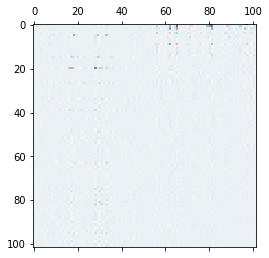

In [39]:
plt.matshow(spoc.filters_[4], cmap='RdBu')

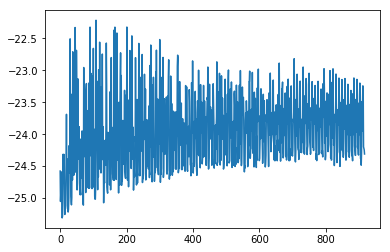

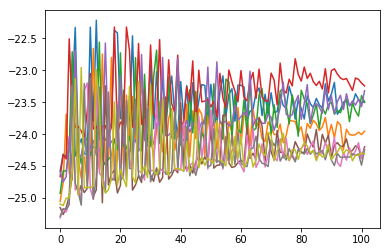

In [40]:
plt.figure()
plt.plot(features[4]);
plt.figure()
plt.plot(features.reshape(len(y), len(picks), len(fbands))[4]);


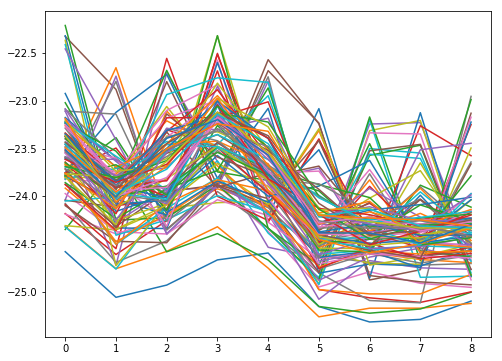

In [41]:
plt.figure(figsize=(8,6))
for ii, comp in enumerate(features[4].reshape(102,9)):
    plt.plot(comp)

In [42]:
spoc.features

array([[-24.06528374, -24.55715541, -24.64991901, ..., -24.42993182,
        -24.46224447, -24.33815706],
       [-24.3212801 , -24.75011841, -24.70753775, ..., -24.32603429,
        -24.24020214, -24.17788727],
       [-25.13273718, -25.64679569, -25.30853955, ..., -24.59188646,
        -24.48987879, -24.3612361 ],
       ...,
       [-24.24732754, -24.70252111, -24.51416463, ..., -24.11281838,
        -24.34839771, -24.28886618],
       [-23.57781324, -24.29017623, -23.45179737, ..., -24.55883518,
        -24.52736747, -24.48142683],
       [-24.03755773, -24.59151149, -24.64761953, ..., -24.36902791,
        -24.38130404, -24.25996837]])

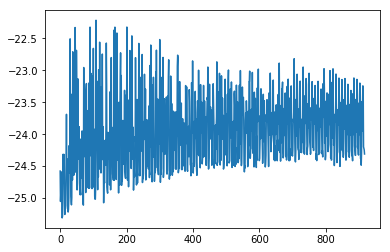

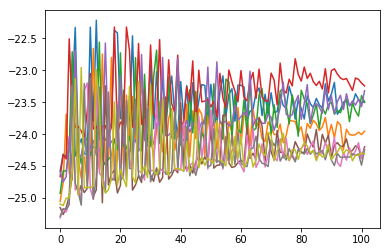

In [43]:
plt.figure()
plt.plot(features[4]);
plt.figure()
plt.plot(features.reshape(len(y), len(picks), len(fbands))[4]);


# Funny observation: some subjects have opposite ordering of power!

_Suspicion: sorting of eigenvectors is probably somehow broken._

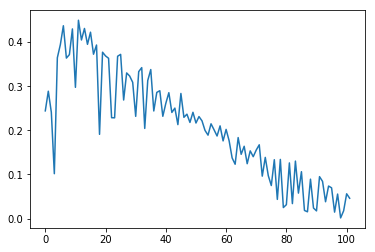

In [60]:
corr = []
features_ = features.reshape(len(y), len(picks), len(fbands))
for comp in range(len(picks)):
    corr_fb = []
    for fb in range(covs.shape[1]):
        powers = features_[:, comp, fb]
        corr_fb.append(np.abs(pearsonr(powers, y))[0])
    corr.append(corr_fb)

plt.close('all')
plt.figure()
plt.plot(np.arange(len(picks)), np.array(corr)[:, 3])
plt.show()

(-26.560257265136126, -21.01403579762432)

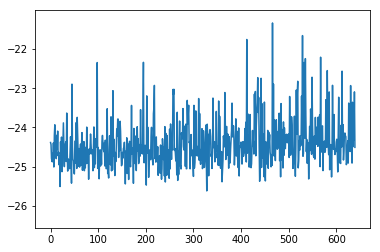

In [45]:
plt.figure()
plt.plot(features_[:, 0, 3])
plt.ylim(features_.min(), features_.max())

In [46]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

n_components = len(picks)
# n_components = 10
spoc = SPoC(covs=covs, fbands=fbands, spoc=True, n_components=102, alpha=0.01)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#ridge = Ridge(alpha=1.)
ridge = RidgeCV(alphas=np.logspace(-3, 5, 100))
scaler = StandardScaler()
pipe = make_pipeline(spoc, scaler, ridge)
scores = -cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error')
print("MAE : %s (%s)" % (np.mean(scores), np.std(scores)))

MAE : 8.878289169988472 (0.7210051092963651)


In [47]:
spoc = SPoC(covs=covs, fbands=fbands, spoc=True, n_components=n_components, alpha=0.01)
Xf = spoc.fit_transform(X, y)
Xf.shape

(640, 918)

In [48]:
from sklearn.feature_selection import f_regression
F, pv = f_regression(Xf, y)

In [52]:
pv = pv.reshape(len(picks), -1)
F = F.reshape(len(picks), -1)

In [53]:
pv.shape, F.shape

((102, 9), (102, 9))

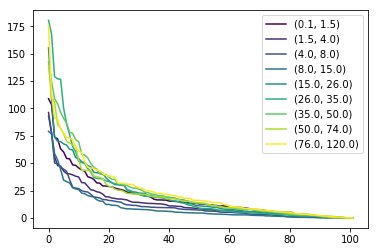

In [55]:
cols = plt.cm.viridis(np.linspace(0, 1, len(fbands)))
#for x, col in zip(-np.log10(pv), cols):
for x, col in zip(F.T, cols):
    plt.plot(np.sort(x)[::-1], color=col)
plt.legend(labels=fbands)

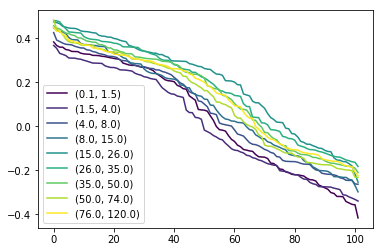

In [56]:
spoc = SPoC(
    covs=covs, fbands=fbands, spoc=True, n_components=n_components)
spoc.fit(X, y)
features = spoc.transform(X).reshape(X.size, len(picks), -1)

corr = list()
for comp in range(len(picks)):
    corr_fb = list()
    for fb in range(covs.shape[1]):
        powers = features[:, comp, fb]
        corr_fb.append(pearsonr(powers, y)[0])
    corr.append(corr_fb)
plt.close('all')
plt.figure()
cols = plt.cm.viridis(np.linspace(0, 1, len(fbands)))
for x, col in zip(np.array(corr).T, cols):
    plt.plot(np.sort(x)[::-1], color=col)
plt.legend(labels=fbands)


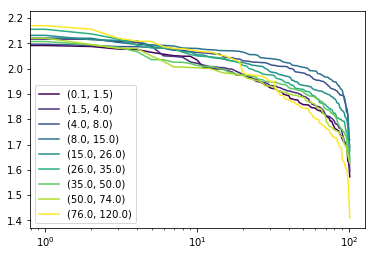

In [59]:
from sklearn.metrics import mutual_info_score
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

corr = list()
for comp in range(len(picks)):
    corr_fb = list()
    for fb in range(covs.shape[1]):
        powers = features[:, comp, fb]
        corr_fb.append(calc_MI(powers, y, 100))
    corr.append(corr_fb)
plt.close('all')
plt.figure()
cols = plt.cm.viridis(np.linspace(0, 1, len(fbands)))
for x, col in zip(np.array(corr).T, cols):
    plt.semilogx(np.sort(x)[::-1], color=col)
plt.legend(labels=fbands)
